# Inverse problem with adj. correction

## Setup

In [1]:
%load_ext autoreload
%autoreload

import dolfinx
import numpy as np
import matplotlib.pyplot as plt
import dolfinx.fem.petsc
import pandas as pd
import scipy as sp
import eitx
import ufl

from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'


<class 'numpy.complex128'>


Error   : Gmsh has not been initialized


Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0400473s, CPU 0.039676s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.229861s, CPU 0.21787s)
Info    : 3070 nodes 5339 elements


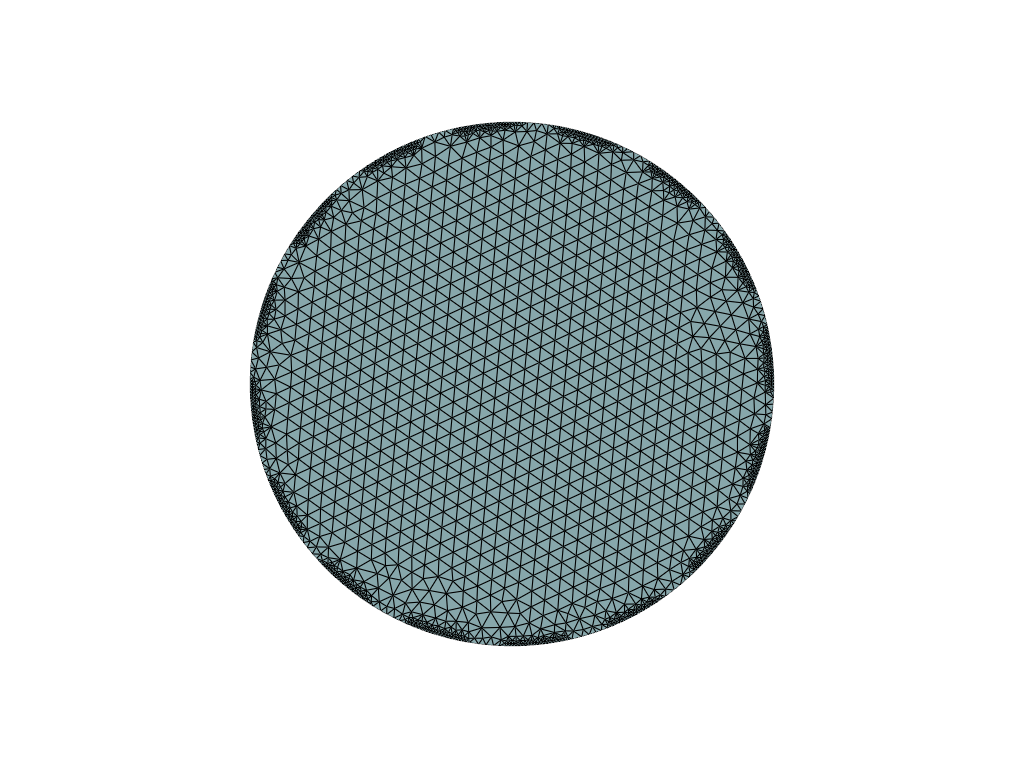

In [2]:
L=16
perc=0.5
electrodes = eitx.Electrodes(L,perc,0)

mesh_refining = 0.3 #scaling factor for all domain refinement
bdr_refining = 0.4 # scaling factor for border refining

mesh_object = eitx.MeshClass(electrodes,mesh_refining,bdr_refining)
mesh_dir = mesh_object.mesh
z_values = np.full(L,0.0025+0.0025j)
dir_problem = eitx.DirectProblem(mesh_object, z_values)
I_all = eitx.current_method(L,15,method=2,value=1)

eitx.plot_mesh(mesh_dir)

In [3]:
V0 = dir_problem.V0
x = ufl.SpatialCoordinate(mesh_dir)

#defining gamma
def gamma_locator(x):
  return (x[0]+0.3)**2 + (x[1]+0.3)**2<=0.3**2
def gamma_locator_2(x):
  return (x[0]-0.3)**2 + (x[1]-0.3)**2<=0.2**2
gamma_sol = dolfinx.fem.Function(V0)
gamma_sol_cells = gamma_locator(V0.tabulate_dof_coordinates().T).astype(int)
gamma_sol_cells2 = gamma_locator_2(V0.tabulate_dof_coordinates().T).astype(int)
gamma_sol.x.array[:] = 1 + 1j + gamma_sol_cells + 2j*gamma_sol_cells2
# gamma_sol = dolfinx.fem.Function(V0)
# expr = 1+1j+ ufl.exp(-(x[0]**2+x[1]**2)/0.2) + 1j*ufl.exp(-(x[0]**2+x[1]**2)/0.2)
# gamma_sol.interpolate(dolfinx.fem.Expression(expr,V0.element.interpolation_points()))

#solving direct problem
dir_problem.set_problem(gamma_sol)
u_list, U_list = dir_problem.solve_problem_current(I_all)

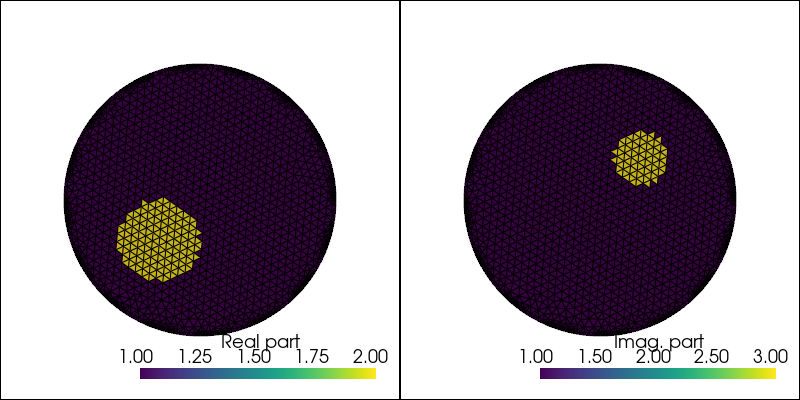

In [4]:
eitx.plot_indicator_function(gamma_sol)

In [5]:
mesh_refining = 0.6 #scaling factor for all domain refinement
bdr_refining = 0.8 # scaling factor for border refining
mesh_inv_object = eitx.MeshClass(electrodes,mesh_refining,bdr_refining)
mesh = mesh_inv_object.mesh

Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.0311831s, CPU 0.031867s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0950212s, CPU 0.095599s)
Info    : 1779 nodes 2757 elements


## Landweber 

In [19]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [20]:
solverconfig_dict= { 
    #General Parameters
    "step_limit": 400,
    "tau": 1,
    "noise_level": 0,
    "weight_value": False,
    "innerstep_limit": 1,
    "land_a": 250,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [21]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
starting outer step 2
starting outer step 3
starting outer step 4
starting outer step 5
starting outer step 6
starting outer step 7
starting outer step 8
starting outer step 9
starting outer step 10
starting outer step 11
starting outer step 12
starting outer step 13
starting outer step 14
starting outer step 15
starting outer step 16
starting outer step 17
starting outer step 18
starting outer step 19
starting outer step 20
starting outer step 21
starting outer step 22
starting outer step 23
starting outer step 24
starting outer step 25
starting outer step 26
starting outer step 27
starting outer step 28
starting outer step 29
starting outer step 30
starting outer step 31
starting outer step 32
starting outer step 33
starting outer step 34
starting outer step 35
starting outer step 36
starting outer step 37
starting outer step 38
starting outer step 39
starting outer step 40
starting outer step 41
starting outer step 42
starting outer step 43
starting outer step 

In [22]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

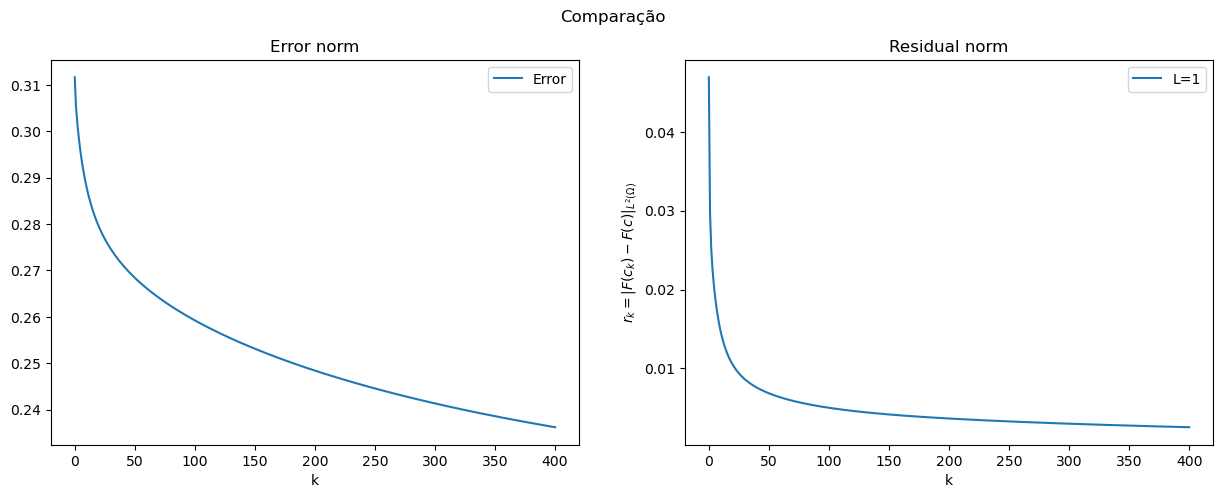

In [23]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

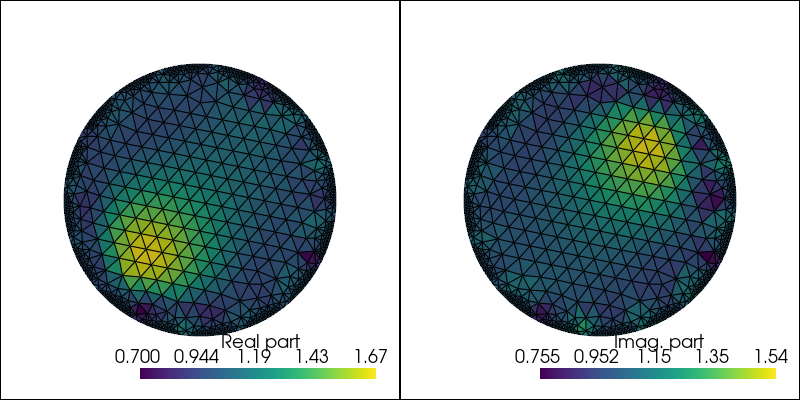

In [24]:
eitx.plot_indicator_function(gamma)

## Levenberg-Marquardt

In [7]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [8]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Tikhonov",
    "step_limit": 10,
    "tau": 1,
    "noise_level": 0,
    "weight_value": False,
    "innerstep_limit": 1,
    "Tik_c0": 0.000001,
    "Tik_q": 1,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [9]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
starting outer step 2
starting outer step 3
starting outer step 4
starting outer step 5
starting outer step 6
starting outer step 7
starting outer step 8
starting outer step 9
starting outer step 10


In [10]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

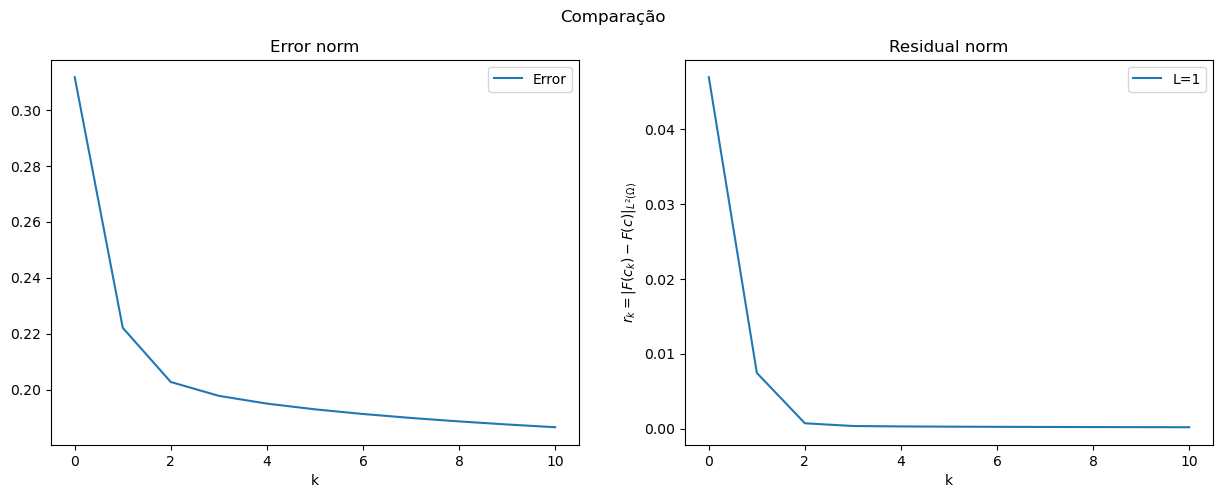

In [11]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

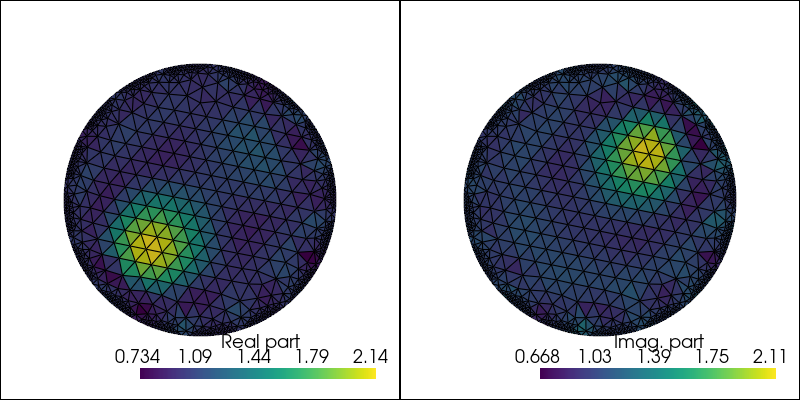

In [12]:
eitx.plot_indicator_function(gamma)

## REGINN-Gradiente

In [28]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [47]:
solverconfig_dict= { 
    #General Parameters
    "step_limit": 20,
    "tau": 1,
    "noise_level": 0,
    "weight_value": True,
    "innerstep_limit": 10,
    "land_a": 0.25,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [48]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
Inner iteration finished with 2 iterations
starting outer step 2
Inner iteration finished with 7 iterations
starting outer step 3
Inner iteration finished with 9 iterations
starting outer step 4
Inner iteration finished with 10 iterations
starting outer step 5
Inner iteration finished with 10 iterations
starting outer step 6
Inner iteration finished with 10 iterations
starting outer step 7
Inner iteration finished with 10 iterations
starting outer step 8
Inner iteration finished with 10 iterations
starting outer step 9
Inner iteration finished with 10 iterations
starting outer step 10
Inner iteration finished with 10 iterations
starting outer step 11
Inner iteration finished with 10 iterations
starting outer step 12
Inner iteration finished with 10 iterations
starting outer step 13
Inner iteration finished with 10 iterations
starting outer step 14
Inner iteration finished with 10 iterations
starting outer step 15
Inner iteration finished with 10 iterations
startin

In [49]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

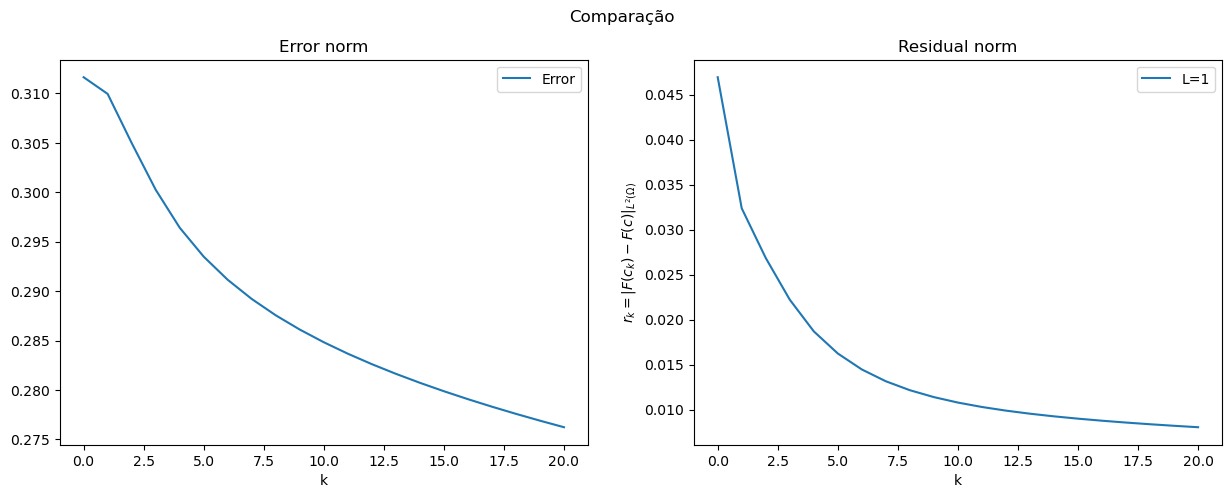

In [50]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

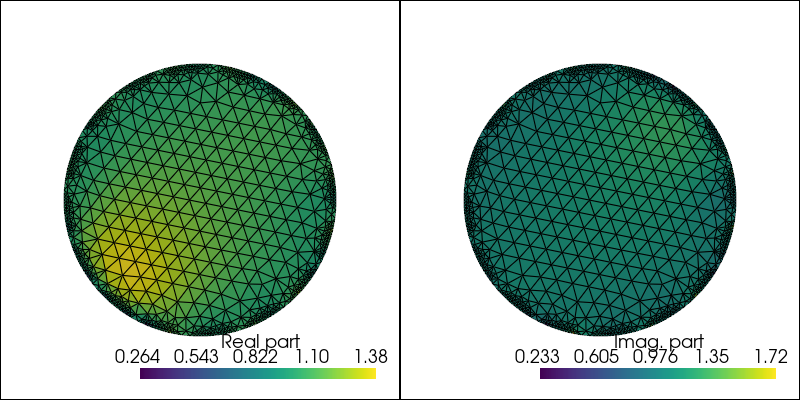

In [51]:
eitx.plot_indicator_function(gamma)

## REGINN-Tikhonov

In [52]:
%autoreload
import eitx
inv_problem = eitx.InverseProblem(mesh_inv_object, z_values, I_all)

In [53]:
solverconfig_dict= { 
    #General Parameters
    "inner_method": "Tikhonov",
    "step_limit": 10,
    "tau": 1,
    "noise_level": 0,
    "weight_value": False,
    "innerstep_limit": 10,
    "Tik_c0": 0.000001,
    "Tik_q": 0.9,
    #General newton method parameters
    "mu_i":0.85,
    "mu_max":0.999,
    "nu":0.97,
    "R":0.97,
}
inv_problem.set_solverconfig(**solverconfig_dict)
inv_problem.set_answer(gamma_sol)

In [54]:
gamma, res_array, err_array = inv_problem.solve_inverse(U_list)


starting outer step 1
Inner iteration finished with 2 iterations
starting outer step 2
Inner iteration finished with 2 iterations
starting outer step 3
Inner iteration finished with 2 iterations
starting outer step 4
Inner iteration finished with 3 iterations
starting outer step 5
Inner iteration finished with 4 iterations
starting outer step 6
Inner iteration finished with 5 iterations
starting outer step 7
Inner iteration finished with 7 iterations
starting outer step 8
Inner iteration finished with 8 iterations
starting outer step 9
Inner iteration finished with 10 iterations
starting outer step 10
Inner iteration finished with 10 iterations


In [55]:
err_array = np.array(err_array)
res_array = np.array(res_array)

Text(0.5, 0.98, 'Comparação')

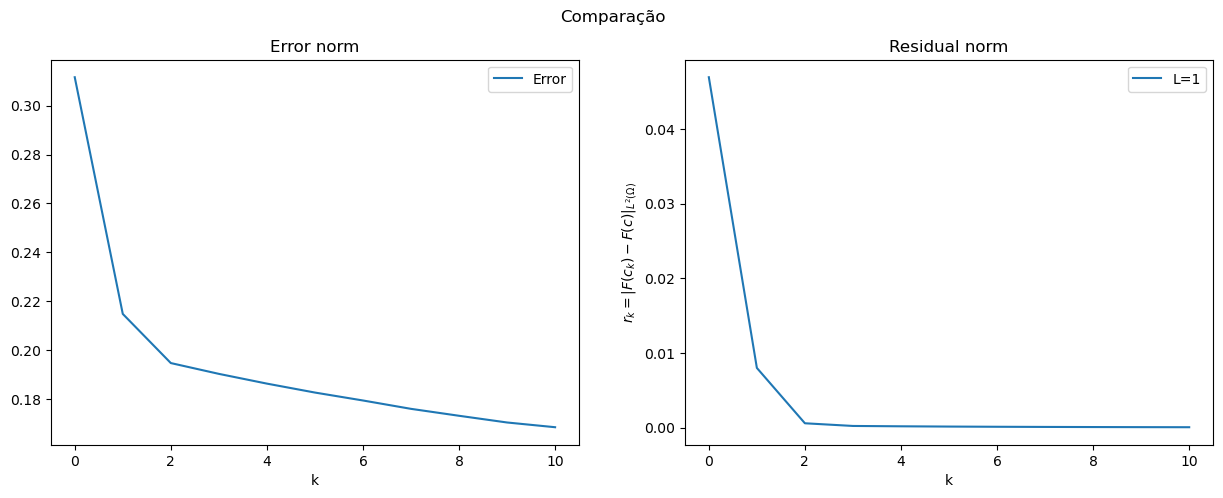

In [56]:
gamma_norm = dolfinx.fem.assemble_scalar(dolfinx.fem.form(ufl.inner(inv_problem.gamma_inv, inv_problem.gamma_inv)*ufl.dx)).real**0.5
U_norm = np.linalg.norm(np.array(U_list).flatten())

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].plot(err_array/gamma_norm,label='Error')
ax[0].set_title("Error norm")
ax[0].set_xlabel("k")
# ax[0].set_yscale("log")
ax[0].legend()

ax[1].plot(res_array/U_norm,label ='L=1')
ax[1].set_title("Residual norm")
ax[1].set_ylabel("$r_k = \|F(c_k) - F(c)\|_{L^2(\Omega)}$")
ax[1].set_xlabel("k")
# ax[1].set_yscale("log")
ax[1].legend()

fig.suptitle("Comparação")

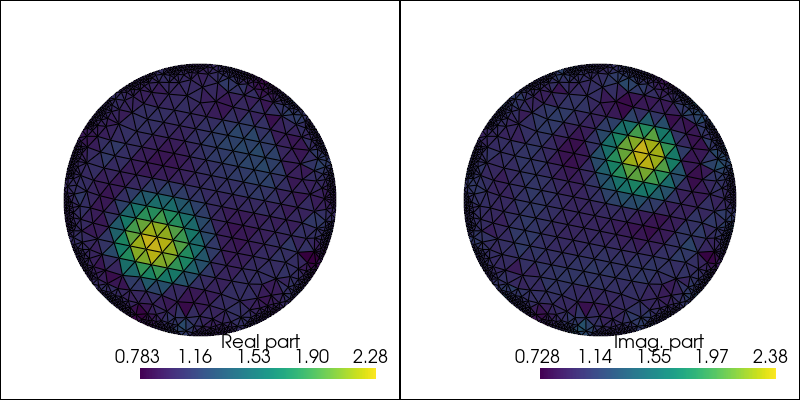

In [57]:
eitx.plot_indicator_function(gamma)